# MCMC: comparison of various algorithms

This script illustrates performance of various MCMC algorithms currently integrated in UQpy:
- Metropolis Hastings (MH)
- Modified Metropolis Hastings (MMH)
- Affine Invariant with Stretch moves (Stretch)
- Adaptive Metropolis with delayed rejection (DRAM)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import multivariate_normal, uniform

from UQpy.SampleMethods import MCMC, MH, Stretch, MMH, DREAM, DRAM, IS
from UQpy.Distributions import Distribution

## Affine invariant with Stretch moves

This algorithm requires as seed a few samples near the region of interest. Here MH is first run to obtain few samples, used as seed within the Stretch algorithm.

In [2]:
def log_Rosenbrock(x):
     return (-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/20)

(5000, 2)


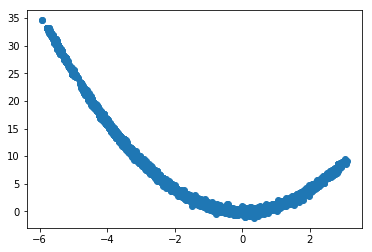

In [3]:
x = MH(dimension=2, nburn=0, jump=10, nsamples=5000, seed=None, log_pdf_target=log_Rosenbrock)
print(x.samples.shape)
plt.plot(x.samples[:,0], x.samples[:,1], 'o')
plt.show()

(5000, 2)


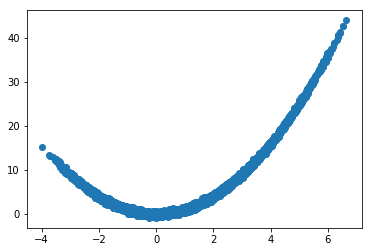

In [4]:
x = Stretch(dimension=2, nburn=0, jump=10, nsamples=5000, log_pdf_target=log_Rosenbrock, seed=x.samples[:10], 
            scale=2.)
print(x.samples.shape)
plt.plot(x.samples[:, 0],x.samples[:, 1],'o')
plt.show()

## DREAM algorithm: compare with MH (inputs parameters are set as their default values)

In [5]:
# Define log_pdf_target
#means = [np.array([10, 1]), np.array([-5, 0])]
#covs = [np.array([[1, 0.02], [0.02, 0.2]]), np.array([[1, -0.02], [-0.02, 0.2]])]
#def log_pdf_bimodal(x):
#    return np.log(0.4*multivariate_normal.pdf(x, mean=means[0], cov=covs[0]) + \
#                  0.6*multivariate_normal.pdf(x, mean=means[1], cov=covs[1]))

# Define a function to sample seed uniformly distributed in the 2d space ([-20, 20], [-4, 4])
from UQpy.Distributions import Uniform, JointInd
prior_sample = lambda nsamples: np.array([[-2, -2]]) + np.array([[4, 4]]) * JointInd(
    [Uniform(), Uniform()]).rvs(nsamples=nsamples)

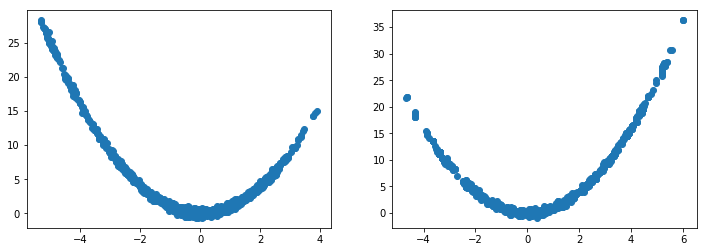

In [6]:
algorithms = [MH, DREAM]
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
for i, algorithm in enumerate(algorithms):
    seed = prior_sample(nsamples=7)
    x = algorithm(dimension=2, nburn=500, jump=50, nsamples=1000, seed=seed, 
                  log_pdf_target=log_Rosenbrock)
    ax[i].plot(x.samples[:, 0], x.samples[:, 1], 'o')
plt.show()

## DRAM algorithm 

time to run MH: 0.9792881011962891s
time to run DRAM: 5.399900913238525s


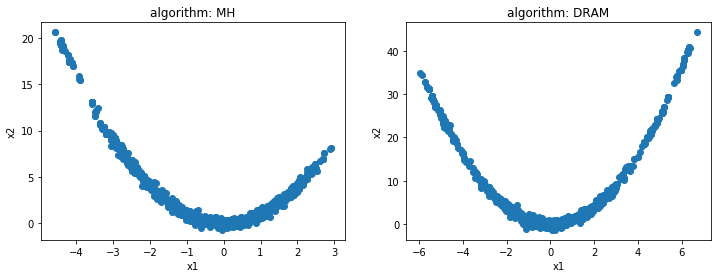

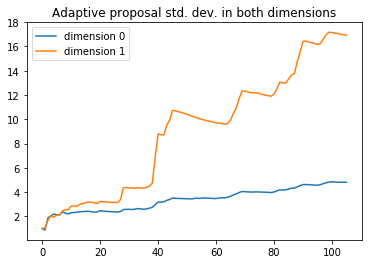

In [7]:
algorithms = ['MH', 'DRAM']
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
for i, algorithm in enumerate(algorithms):
    t = time.time()
    seed = prior_sample(nsamples=1)
    if algorithm == 'MH':
        x = MH(dimension=2, nburn=500, jump=10, nsamples=1000, seed=seed, log_pdf_target=log_Rosenbrock)
    elif algorithm == 'DRAM':
        x = DRAM(dimension=2, nburn=500, jump=10, nsamples=1000, seed=seed, log_pdf_target=log_Rosenbrock, 
                 save_covariance=True)
    ax[i].plot(x.samples[:, 0], x.samples[:, 1], 'o')
    ax[i].set_xlabel('x1')
    ax[i].set_ylabel('x2')
    ax[i].set_title('algorithm: '+algorithm)
    print('time to run '+algorithm+': {}s'.format(time.time()-t))
plt.show()

# look at the covariance adaptivity
fig, ax = plt.subplots()
adaptive_covariance = np.array(x.adaptive_covariance)
for i in range(2):
    ax.plot(np.sqrt(adaptive_covariance[:, 0, i, i]), label='dimension {}'.format(i))
ax.set_title('Adaptive proposal std. dev. in both dimensions')
ax.legend()
plt.show()

## MMH: target pdf is given as a joint pdf

The target pdf should be a 1 dimensional distribution or set of 1d distributions.

In [9]:
from UQpy.Distributions import Normal
proposal = [Normal(), Normal()]
proposal_is_symmetric = [False, False]

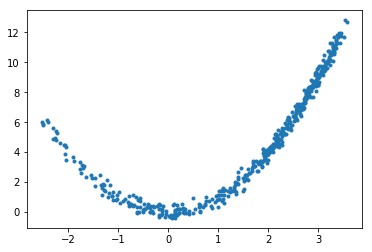

In [10]:
x = MMH(dimension=2, nburn=500, jump=50, nsamples=500, log_pdf_target=log_Rosenbrock,
        proposal=proposal, proposal_is_symmetric=proposal_is_symmetric)

fig, ax = plt.subplots()
ax.plot(x.samples[:, 0], x.samples[:, 1], linestyle='none', marker='.')

## MMH: target pdf is given as a couple of independent marginals

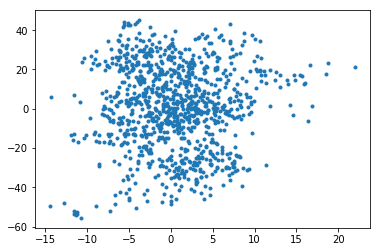

(1000, 2)


In [12]:
log_pdf_target = [Normal(loc=0., scale=5.).log_pdf, Normal(loc=0., scale=20.).log_pdf]

proposal = [Normal(), Normal()]
proposal_is_symmetric = [True, True]

x = MMH(dimension=2, nburn=100, jump=10, nsamples=1000, log_pdf_target=log_pdf_target, 
        proposal=proposal, proposal_is_symmetric=proposal_is_symmetric)

fig, ax = plt.subplots()
ax.plot(x.samples[:, 0], x.samples[:, 1], linestyle='none', marker='.')
plt.show(fig)
print(x.samples.shape)